In [1]:
import h5py
import numpy as np
from tqdm import tqdm
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

from orbit_evolution_potential import NFW, LeepFrog, Rx, Ry, Rz, run
from dynesty_NestedSampling import model, get_gamma, log_likelihood_density, prior_transform, generate_data, log_likelihood_GMM, log_likelihood_phi

Text(0, 0.5, '$y$')

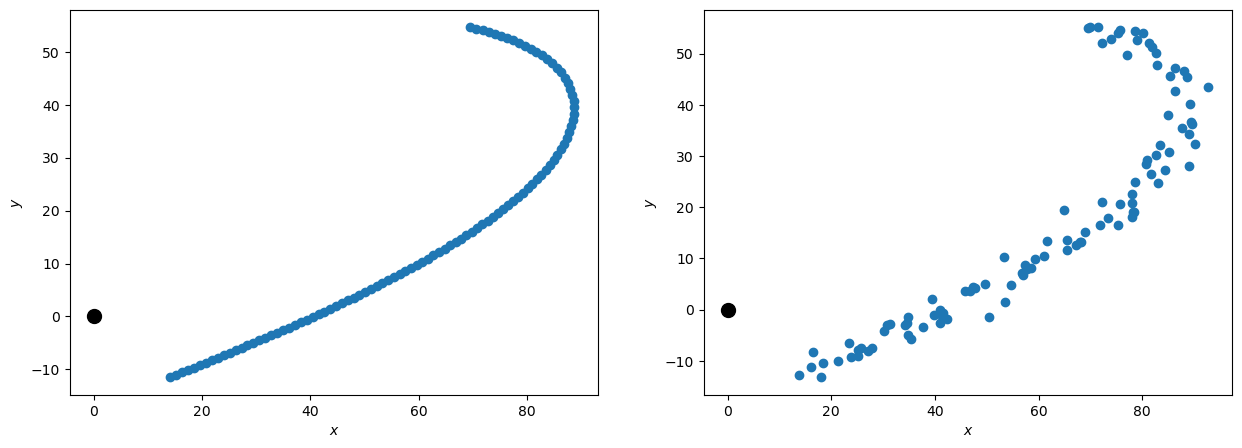

In [18]:
clean_data, dirty_data, sigma, theo_params = generate_data(data_type='xy', ndim=16, seed=99)
dict_data = {'clean_data': clean_data, 'dirty_data': dirty_data, 'sigma': sigma}

### Plot ###
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(clean_data[0], clean_data[1])
plt.scatter(0,0, c='k', s=100)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.subplot(1,2,2)
plt.scatter(dirty_data[0], dirty_data[1])
plt.scatter(0,0, c='k', s=100)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

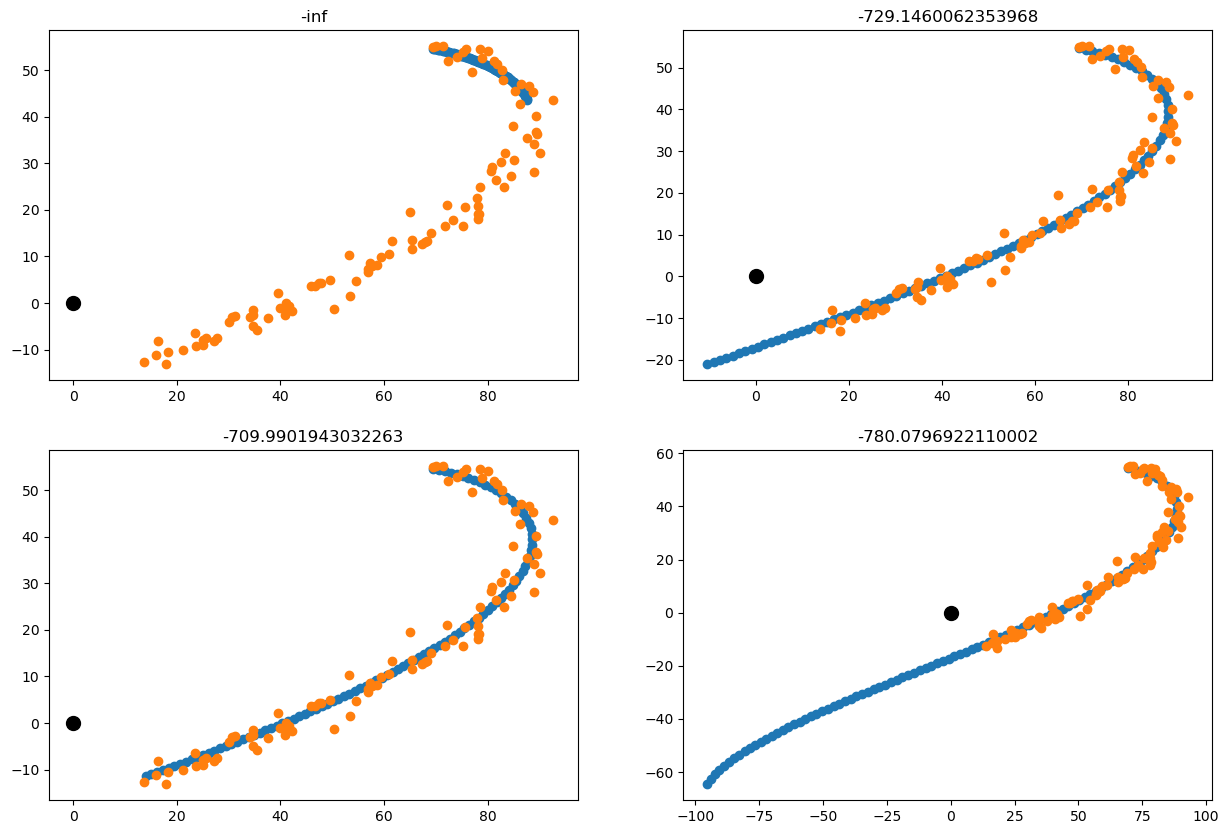

In [20]:
params_0 = np.array(theo_params)#.copy()
params_0[-6] = 0.4
model_0 = model(params_0)

params_1 = np.array(theo_params)#.copy()
params_1[-6] = 2
model_1 = model(params_1)

params_2 = np.array(theo_params)#.copy()
params_2[-6] = theo_params[-6]
model_2 = model(params_2)

params_3 = np.array(theo_params)#.copy()
params_3[-6] = 3.2
model_3 = model(params_3)

log_likelihood_function = log_likelihood_GMM

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title(log_likelihood_function(params_0, dict_data))
plt.scatter(model_0[0], model_0[1])
plt.scatter(dirty_data[0], dirty_data[1])
plt.scatter(0,0, c='k', s=100)
plt.subplot(2,2,2)
plt.title(log_likelihood_function(params_1, dict_data))
plt.scatter(model_1[0], model_1[1])
plt.scatter(dirty_data[0], dirty_data[1])
plt.scatter(0,0, c='k', s=100)
plt.subplot(2,2,3)
plt.title(log_likelihood_function(params_2, dict_data))
plt.scatter(model_2[0], model_2[1])
plt.scatter(dirty_data[0], dirty_data[1])
plt.scatter(0,0, c='k', s=100)
plt.subplot(2,2,4)
plt.title(log_likelihood_function(params_3, dict_data))
plt.scatter(model_3[0], model_3[1])
plt.scatter(dirty_data[0], dirty_data[1])
plt.scatter(0,0, c='k', s=100)

Text(0, 0.5, '$y$')

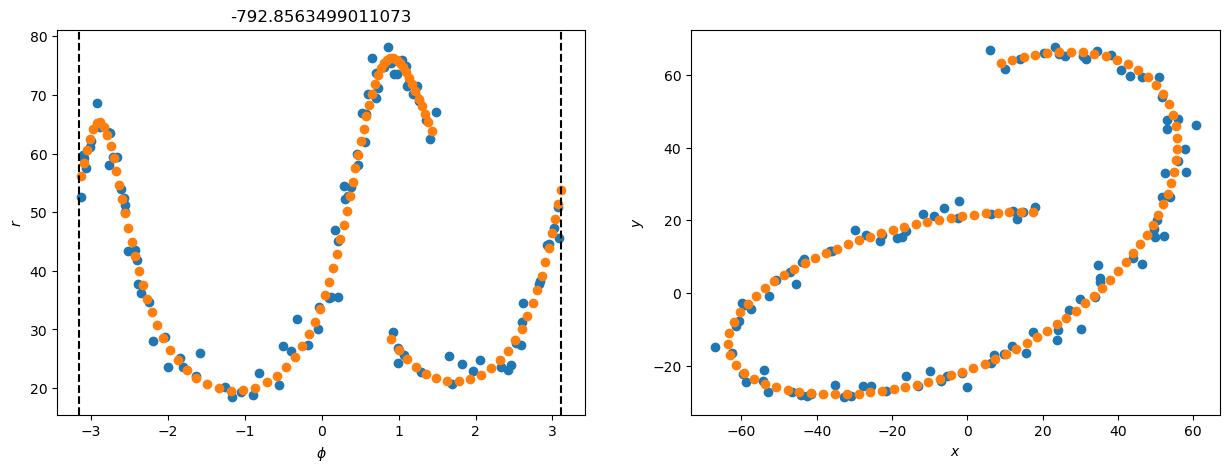

In [4]:
count  = 16
utheta = np.random.rand(count)
params = theo_params #prior_transform(utheta) 

model_data = model(params)

r_data = np.sqrt(dirty_data[0]**2 + dirty_data[1]**2)
phi_data = np.arctan2(dirty_data[1], dirty_data[0])

r_model = np.sqrt(model_data[0]**2 + model_data[1]**2)
phi_model = np.arctan2(model_data[1], model_data[0])

# Based on FOV of data
padding = 0.01
sign_min, sign_max = phi_data.min()/abs(phi_data.min()), phi_data.max()/abs(phi_data.max())

if sign_min < 0:
    phi_min_limit = phi_data.min()*(1+padding)
elif sign_min > 0:
    phi_min_limit = phi_data.min()*(1-padding)
else:
    phi_min_limit = phi_data.min()
if sign_max < 0:
    phi_max_limit = phi_data.max()*(1-padding)
elif sign_max > 0:
    phi_max_limit = phi_data.max()*(1+padding)
else:
    phi_max_limit = phi_data.max()

arg_in  = np.where( (phi_model.min() < phi_data) &  (phi_data < phi_model.max()) )[0]
arg_out = np.where( (phi_model < phi_min_limit) &  (phi_model > phi_max_limit) )[0]

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title(log_likelihood_prob(params, dict_data))
plt.scatter(phi_data, r_data)
plt.scatter(phi_model, r_model)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$r$')
plt.axvline(phi_min_limit, c='k', ls='--')
plt.axvline(phi_max_limit, c='k', ls='--')
plt.subplot(1,2,2)
plt.scatter(r_data*np.cos(phi_data), r_data*np.sin(phi_data))
plt.scatter(r_model*np.cos(phi_model), r_model*np.sin(phi_model))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

In [16]:
import pickle

seed = 99
directory_path = f'./dynesty_results_N100_GMM_seed{seed}'

# Data
with open(f'{directory_path}/data_dict.pkl', 'rb') as file:
    data = pickle.load(file)

# Dynesty results
with open(f'{directory_path}/dynesty_results.pkl', 'rb') as file:
    results = pickle.load(file)

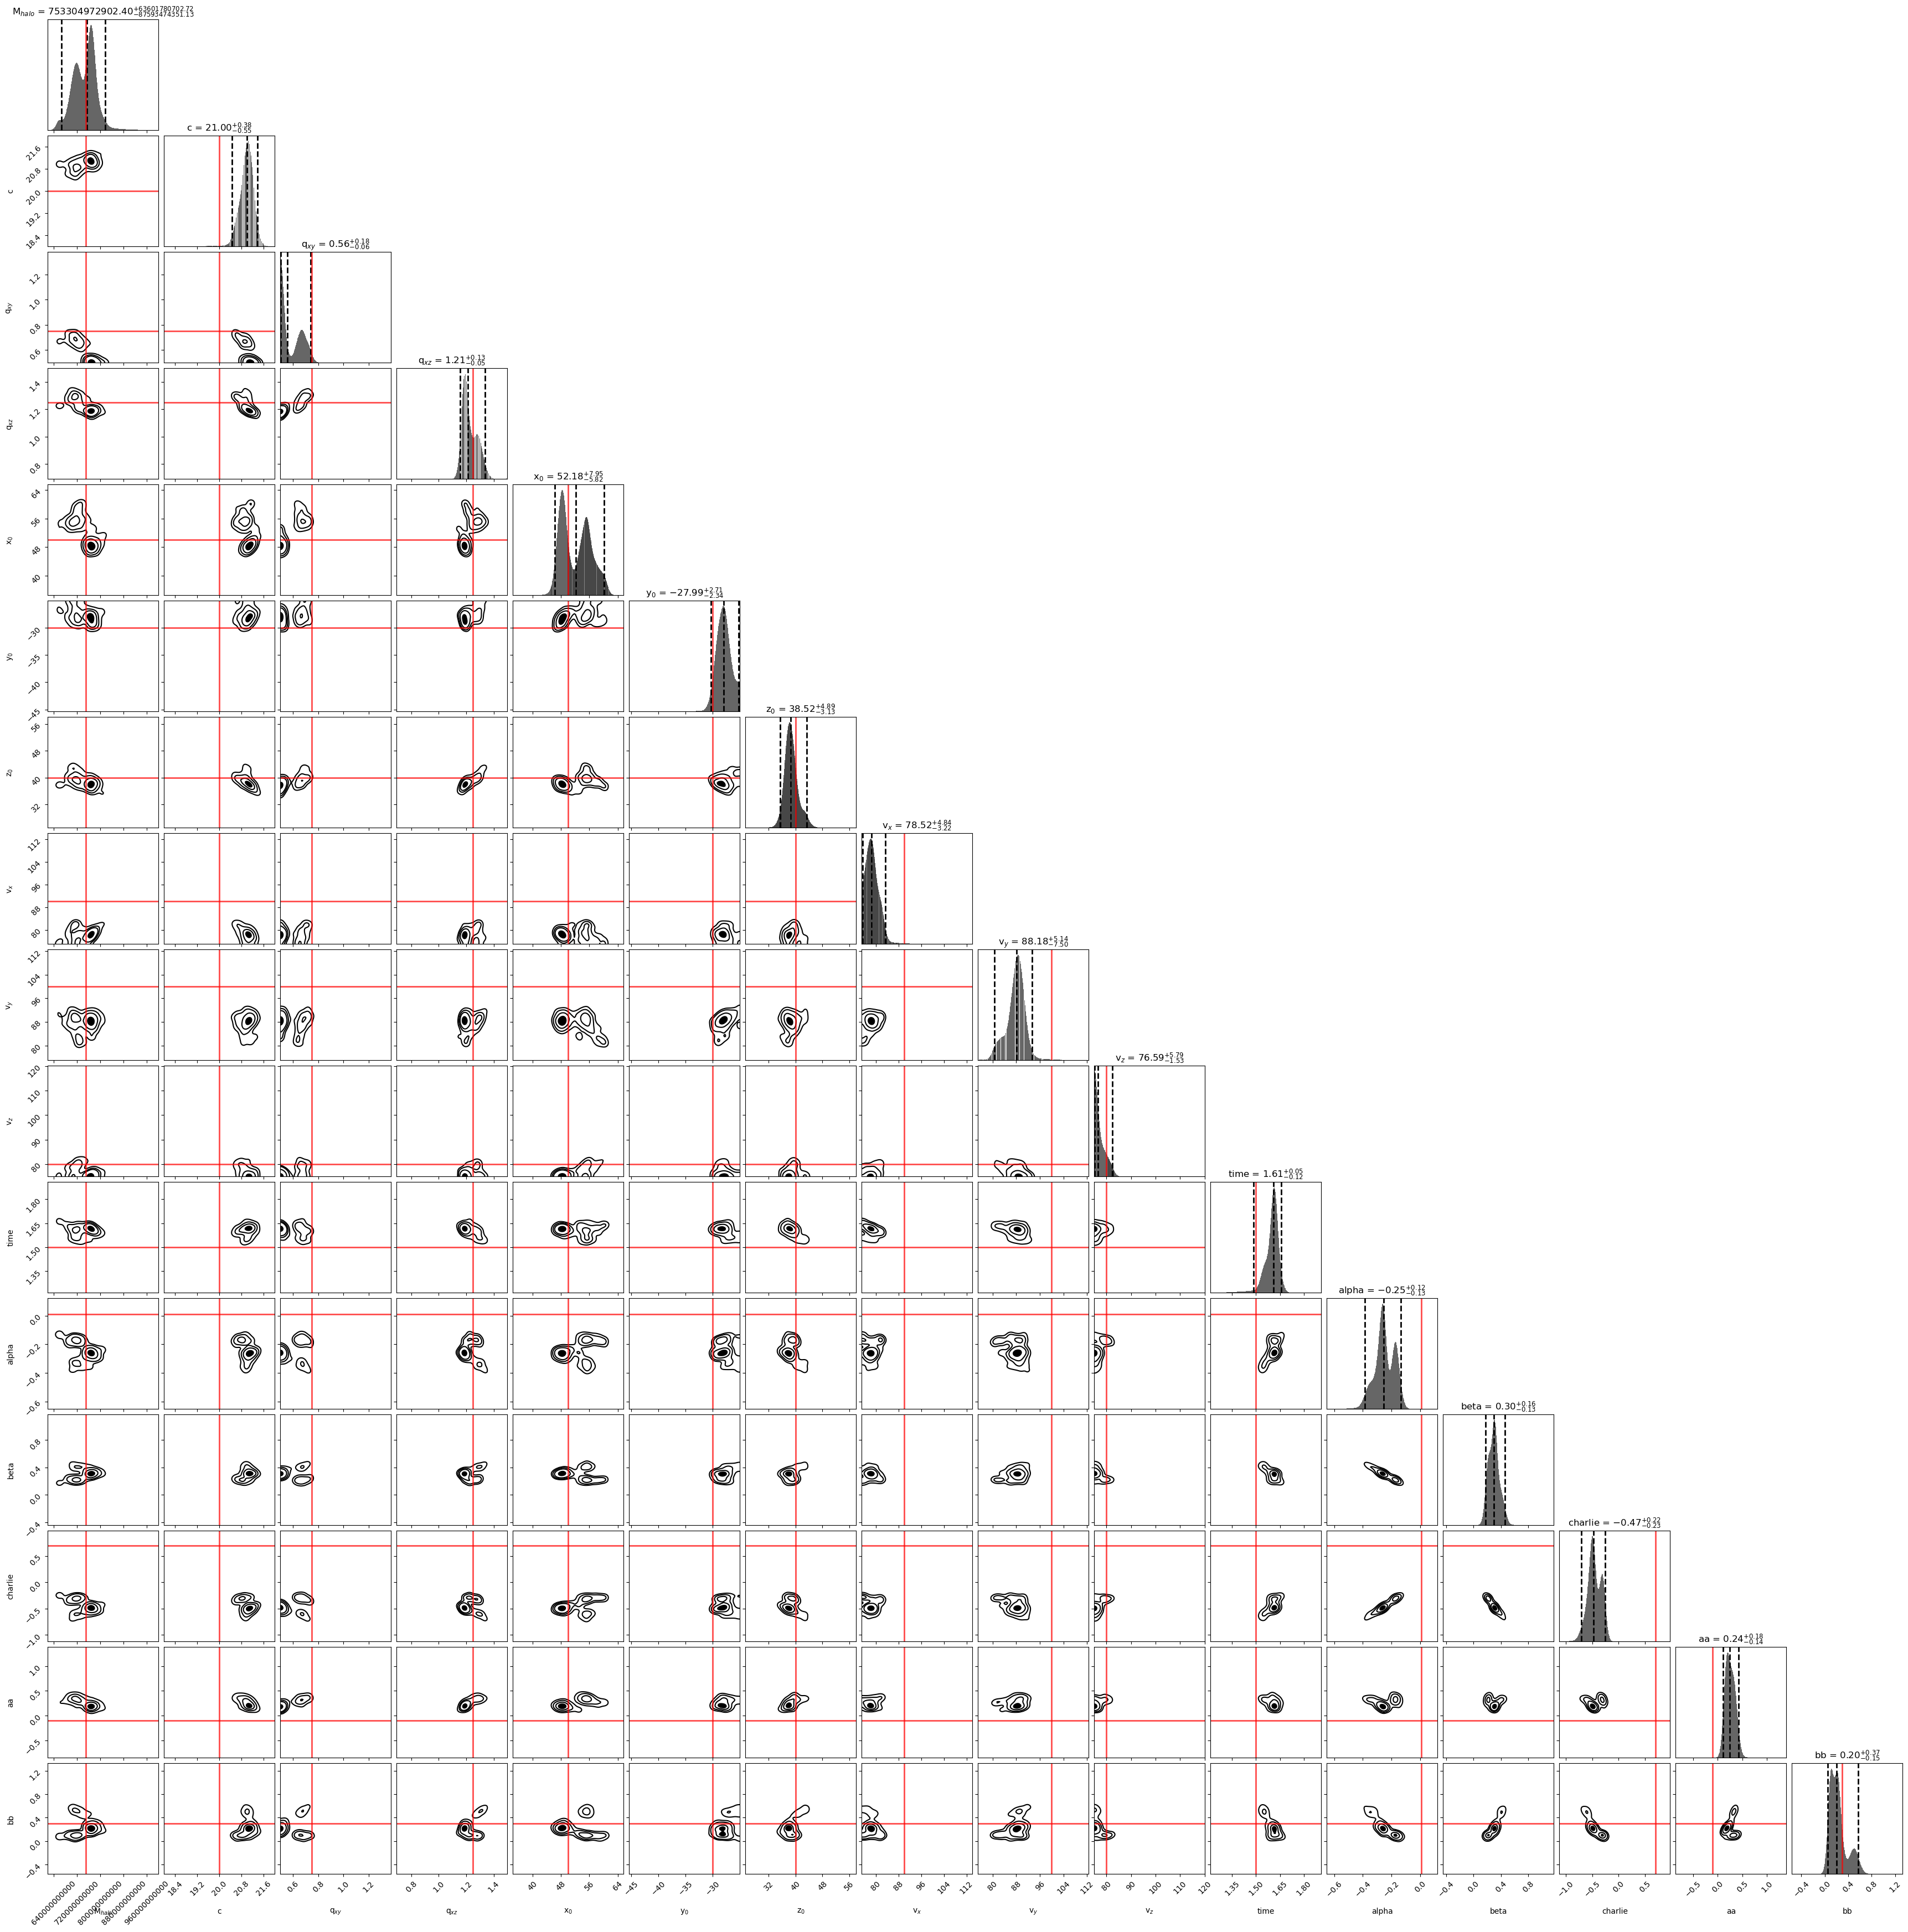

In [18]:
from dynesty import plotting as dyplot


# Plot a subset of parameters
labels = [r'M$_{halo}$', 'c', r'q$_{xy}$', r'q$_{xz}$', r'x$_0$', r'y$_0$', r'z$_0$', r'v$_x$', r'v$_y$', r'v$_z$', 'time', 'alpha', 'beta', 'charlie', 'aa', 'bb']
truths = [halo_mass, concentration, flattening_xy, flattening_xz, pos_init[0], pos_init[1], pos_init[2], vel_init[0], vel_init[1], vel_init[2], t_end, alpha, beta, charlie, aa, bb]
fig, axes = dyplot.cornerplot(results, truths=truths, labels=labels, show_titles=True)

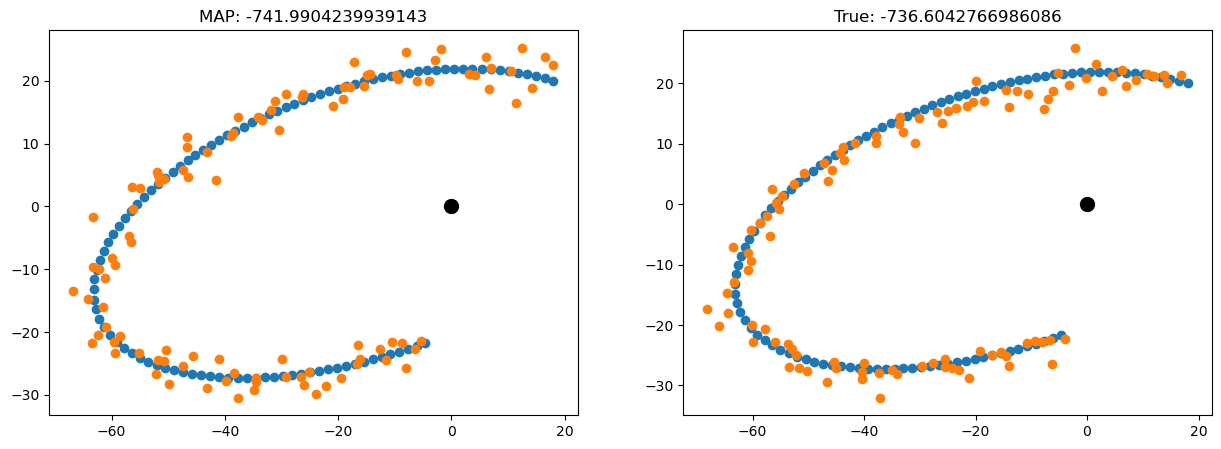

In [28]:
# Extract weighted samples
samples = results.samples
weights = np.exp(results.logwt - results.logz[-1])

# Compute the weighted mean of the samples
mean_fit_params = np.sum(samples * weights.reshape(-1, 1), axis=0) / np.sum(weights)

# Compute the maximum log-likelihood
max_logl_index = np.argmax(results.logl)
max_logl_sample = results.samples[max_logl_index]
max_logl_value = results.logl[max_logl_index]

max_fit = model(max_logl_sample)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title(f'MAP: {log_likelihood_GMM(max_logl_sample, data)}')
plt.scatter(max_fit[0], max_fit[1])
plt.scatter(data['dirty_data'][0], data['dirty_data'][1])
plt.scatter(0,0, c='k', s=100)
plt.subplot(1,2,2)
plt.title(f'True: {log_likelihood_GMM(max_logl_sample, dict_data)}')
plt.scatter(max_fit[0], max_fit[1])
plt.scatter(dirty_data[0], dirty_data[1])
plt.scatter(0,0, c='k', s=100)